In [6]:
!pip install git+https://github.com/feralvam/easse.git

  Cloning https://github.com/feralvam/easse.git to /private/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/pip-req-build-jbffch4a
  Running command git clone --filter=blob:none --quiet https://github.com/feralvam/easse.git /private/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/pip-req-build-jbffch4a
  Resolved https://github.com/feralvam/easse.git to commit 6a4352ec299ed03fda8ee45445ca43d9c7673e89
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/text-simplification-evaluation.git (to revision main) to /private/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/pip-install-b_5lx99h/tseval_c5cafa1790bd4edb8885821082746315
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/text-simplification-evaluation.git /private/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/pip-install-b_5lx99h/tseval_c5cafa1790bd4edb8885821082746315
  Resolved https://github.com/facebookresearch/te

In [8]:
!pip install sacrebleu rouge-score textstat ruts openpyxl

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 552.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 711.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.5 MB/s eta 0:00:00a 0:00:01
  DEPRECATION: Building 'docopt' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'docopt'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=735cc951a05aff6d9d5e39171de96eec3c93eb6e00bf6e8294cc6f142ab87637
  Stored in directory: /Users/aleksandraskorodumova/Library/Caches/pip/wheels/1a/bf/a1/

In [40]:
# В начале ноутбука добавьте «заплатку» для pymorphy2/inspect:
import inspect
if not hasattr(inspect, 'getargspec'):
    inspect.getargspec = inspect.getfullargspec

In [42]:
# Автоматическое объединение, оценка и визуализация результатов упрощения

## 1. Импорты и установка зависимостей

import os, glob, re
import pandas as pd
import matplotlib.pyplot as plt

from easse.sari import corpus_sari
import sacrebleu
from rouge_score import rouge_scorer
import textstat
import ruts

In [44]:
files = glob.glob('*.xlsx')
print(files)

['unique_texts_200_formatted_golden_standard_rugpt_base.xlsx', 'unique_texts_200_formatted_golden_standard_llama_base.xlsx', 'unique_texts_200_formatted_golden_standard_vikhr_llama.xlsx', 'unique_texts_200_qwen_results_final.xlsx', 'unique_texts_200_formatted_golden_standard_qwen_base.xlsx', 'unique_texts_200_formatted_golden_standard_rugpt_v2.xlsx']


In [46]:
## 2. Объединяем шесть файлов в один DataFrame

# Путь к папке
PATH = '.'
files = glob.glob(os.path.join(PATH, '*.xlsx'))

# Собираем все таблицы в список
dfs = []
for fp in files:
    df = pd.read_excel(fp)
    # нормализуем имена колонок
    df.columns = df.columns.str.strip()
    dfs.append(df)

# Начинаем с первого DataFrame, оставляя только оригинал и эталон
base = dfs[0][['unique_text', 'golden_standard']].copy()
for df in dfs:
    # находим колонку с выходами модели
    model_cols = [c for c in df.columns if c not in ['unique_text', 'golden_standard']]
    if len(model_cols) != 1:
        raise ValueError(f"В файле {df} неожиданное число колонок моделей: {model_cols}")
    col = model_cols[0]
    base = base.merge(df[['unique_text', col]],
                      on='unique_text', how='left')

# Переименуем для удобства
base = base.rename(columns={
    'unique_text': 'original_text',
    'golden_standard': 'reference'
})

# Порядок столбцов: оригинал → эталон → все модели
model_cols = [c for c in base.columns if c not in ['original_text','reference']]
base = base[['original_text','reference'] + model_cols]

# Сохраним промежуточный CSV
base.to_csv('combined_results.csv', index=False)

In [48]:
## 3. Очистка текстов от пустых строк (нужна для стабильности SARI)

def normalize(text):
    if pd.isna(text): return ''
    lines = [ln.strip() for ln in str(text).splitlines() if ln.strip()]
    return "\n".join(lines)

for col in base.columns:
    base[col] = base[col].apply(normalize)


In [32]:
## 4. Подсчёт метрик вручную

# Подготовка исходных списков
srcs = base['original_text'].tolist()
refs = [ base['reference'].tolist() ]  # один список длины N
hyps = base[m].tolist()
sari = corpus_sari(srcs, hyps, refs)

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
results = []

for m in model_cols:
    hyps = base[m].tolist()
    # SARI
    sari = corpus_sari(srcs, hyps, refs)
    # BLEU
    bleu = sacrebleu.corpus_bleu(hyps, [base['reference'].tolist()]).score
    # ROUGE
    scores = [scorer.score(r[0], h) for h, r in zip(hyps, refs)]
    rouge1 = sum(s['rouge1'].fmeasure for s in scores)/len(scores)
    rouge2 = sum(s['rouge2'].fmeasure for s in scores)/len(scores)
    rougeL = sum(s['rougeL'].fmeasure for s in scores)/len(scores)
    # Доп. метрика: читаемость Flesch-Reading-Ease
    fre = textstat.flesch_reading_ease(" ".join(hyps))
    results.append({
        'model': m,
        'sari': round(sari,2),
        'bleu': round(bleu,2),
        'rouge1': round(rouge1,2),
        'rouge2': round(rouge2,2),
        'rougeL': round(rougeL,2),
        'flesch_reading': round(fre,2)
    })

metrics_df = pd.DataFrame(results).sort_values('sari', ascending=False)
metrics_df.to_csv('model_metrics.csv', index=False)
metrics_df


,model,sari,bleu,rouge1,rouge2,rougeL,flesch_reading
2,llama_finetuned,47.99,38.17,0.0,0.0,0.0,108.20
3,qwen_finetuned,40.01,15.57,0.0,0.0,0.0,109.24
1,llama_base,35.14,13.26,0.0,0.0,0.0,108.93
0,base_model_rugpt,32.89,14.78,0.0,0.0,0.0,105.18
4,qwen_base,26.73,2.13,0.0,0.0,0.0,109.39
5,finetuned_model_rugpt,24.61,0.52,0.0,0.0,0.0,102.56


In [52]:
import inspect

if not hasattr(inspect, 'getargspec'):
    full = inspect.getfullargspec
    def getargspec(func):
        spec = full(func)
        return spec.args, spec.varargs, spec.varkw, spec.defaults
    inspect.getargspec = getargspec

In [56]:
from ruts import BasicStats, DiversityStats, ReadabilityStats

ruts_results = []
for m in model_cols:
    hyps = [h for h in base[m].tolist() if isinstance(h, str) and h.strip()]
    text_all = "\n".join(hyps)

    bs = BasicStats(text_all).get_stats()
    ds = DiversityStats(text_all).get_stats()
    rs = ReadabilityStats(text_all).get_stats()

    # MorphStats может падать — обернём в try/except
    try:
        from ruts import MorphStats
        ms = MorphStats(text_all).get_stats()
    except Exception:
        ms = {}

    entry = {'model': m}
    entry.update(bs); entry.update(ds); entry.update(ms); entry.update(rs)
    ruts_results.append(entry)

ruts_df = pd.DataFrame(ruts_results)


In [58]:
ruts_df.to_csv('ruts_statistics.csv', index=False)
ruts_df

,model,c_letters,c_syllables,n_sents,n_words,n_unique_words,n_long_words,n_complex_words,n_simple_words,n_monosyllable_words,...,mamtld,hdd,simpson_index,hapax_index,flesch_kincaid_grade,flesch_reading_easy,coleman_liau_index,smog_index,automated_readability_index,lix
0,base_model_rugpt,"{1: 2300, 2: 1610, 3: 1407, 4: 1101, 5: 1744, ...","{0: 2649, 1: 3101, 2: 4011, 3: 4065, 4: 2510, ...",1170,19167,3937,11005,5341,11177,3101,...,63.504116,0.932934,235.803643,866.859417,9.996275,32.743796,11.243847,18.939797,11.243847,73.798444
1,llama_base,"{1: 2714, 2: 2486, 3: 2134, 4: 1557, 5: 2403, ...","{0: 3040, 1: 4637, 2: 5677, 3: 4936, 4: 3618, ...",2101,25201,4144,13907,6911,15250,4637,...,65.393436,0.924089,213.737573,842.469989,7.777137,39.018363,9.727789,16.084904,9.727789,67.179082
2,llama_finetuned,"{1: 3006, 2: 2459, 3: 2319, 4: 1676, 5: 2601, ...","{0: 4078, 1: 4218, 2: 6160, 3: 5779, 4: 3954, ...",2135,28294,6960,16233,8059,16157,4218,...,133.607189,0.943864,291.023824,992.434102,8.566513,35.958203,10.575825,17.227129,10.575825,70.625047
3,qwen_finetuned,"{1: 2481, 2: 3628, 3: 1999, 4: 1363, 5: 2192, ...","{0: 5035, 1: 3304, 2: 5375, 3: 5236, 4: 3498, ...",2056,25815,6468,14152,6865,13915,3304,...,146.887940,0.906201,121.273983,1046.808105,7.138964,45.806665,8.032386,16.205398,8.032386,67.376774
4,qwen_base,"{1: 1341, 2: 712, 3: 1160, 4: 675, 5: 1100, 6:...","{0: 1431, 1: 1970, 2: 2455, 3: 2549, 4: 1780, ...",1244,12830,4548,7842,4425,6974,1970,...,246.107758,0.947654,314.886229,1181.050242,11.407125,4.536376,18.127658,16.724599,18.127658,71.435874
5,finetuned_model_rugpt,"{1: 1249, 2: 1612, 3: 1434, 4: 893, 5: 1500, 6...","{0: 2865, 1: 2083, 2: 3131, 3: 3666, 4: 2114, ...",1126,15995,4606,9307,4250,8880,2083,...,544.474225,0.952707,348.487573,1103.965304,8.485204,39.232380,9.728845,17.226482,9.728845,72.392084


In [60]:
import re

# 1) Функция Флеша–Кинкейда (адаптированная для русского)
def fk_grade(text: str) -> float:
    # Разбиваем на предложения
    sents = [s for s in re.split(r'[.!?]+', text) if s.strip()]
    num_sentences = len(sents) or 1

    # Извлекаем слова
    words = re.findall(r'\w+', text, flags=re.UNICODE)
    num_words = len(words) or 1

    # Считаем слоги как количество гласных
    vowels = set('аеёиоуыэюяАЕЁИОУЫЭЮЯ')
    syllable_count = sum(1 for w in words for ch in w if ch in vowels)

    # Собственно формула
    return 0.5 * (num_words / num_sentences) + 8.4 * (syllable_count / num_words) - 15.59

# 2) Пример интеграции в ваш вычислительный блок
results = []
for m in model_cols:
    hyp_text = " ".join([h for h in base[m].tolist() if h.strip()])
    fk  = fk_grade(hyp_text)

    # остальные ваши метрики: sari, bleu, rouge...
    sari = corpus_sari(srcs, base[m].tolist(), [base['reference'].tolist()])
    bleu = sacrebleu.corpus_bleu(base[m].tolist(), [base['reference'].tolist()]).score

    results.append({
        'model': m,
        'sari': round(sari,2),
        'bleu': round(bleu,2),
        'fk_grade': round(fk,2),
        # ...другие метрики
    })

metrics_df = pd.DataFrame(results).sort_values('sari', ascending=False)
metrics_df


,model,sari,bleu,fk_grade
2,llama_finetuned,47.99,38.17,10.93
3,qwen_finetuned,40.01,15.57,10.72
1,llama_base,35.14,13.26,10.37
0,base_model_rugpt,32.89,14.78,10.47
4,qwen_base,26.73,2.13,15.50
5,finetuned_model_rugpt,24.61,0.52,12.35


In [66]:
from nltk.translate.meteor_score import meteor_score

results = []
for m in model_cols:
    hyps = base[m].tolist()
    # SARI
    sari = corpus_sari(srcs, hyps, [refs_single])
    # BLEU
    bleu = sacrebleu.corpus_bleu(hyps, [refs_single]).score

    # METEOR: каждый раз передаём списки слов
    meteor_scores = [
        meteor_score([ref.split()], hyp.split())
        for ref, hyp in zip(refs_single, hyps)
        if hyp.strip()
    ]
    meteor = 100 * sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0

    results.append({
        'model': m,
        'sari': round(sari, 2),
        'bleu': round(bleu, 2),
        'meteor': round(meteor, 2),
    })

metrics_df = pd.DataFrame(results).sort_values('sari', ascending=False)
metrics_df


,model,sari,bleu,meteor
2,llama_finetuned,47.99,38.17,54.98
3,qwen_finetuned,40.01,15.57,30.33
1,llama_base,35.14,13.26,21.12
0,base_model_rugpt,32.89,14.78,20.74
4,qwen_base,26.73,2.13,6.95
5,finetuned_model_rugpt,24.61,0.52,3.79


In [68]:
import pandas as pd
import inspect
from ruts import BasicStats, DiversityStats, ReadabilityStats, MorphStats
import matplotlib.pyplot as plt

In [70]:
# Патч для pymorphy2/inspect (нужно до первого импорта MorphStats)
if not hasattr(inspect, 'getargspec'):
    full = inspect.getfullargspec
    def getargspec(func):
        spec = full(func)
        return spec.args, spec.varargs, spec.varkw, spec.defaults
    inspect.getargspec = getargspec

# 1. Загрузить объединённый CSV (созданный ранее)
base = pd.read_csv('combined_results.csv')

# 2. Рассчитать ruts-метрики для каждого столбца
ruts_results = []
for col in base.columns:
    texts = [t for t in base[col].astype(str).tolist() if t.strip()]
    text_all = "\n".join(texts)

    bs = BasicStats(text_all).get_stats()
    ds = DiversityStats(text_all).get_stats()
    rs = ReadabilityStats(text_all).get_stats()
    try:
        ms = MorphStats(text_all).get_stats()
    except Exception:
        ms = {}

    stats = {}
    stats.update(bs); stats.update(ds); stats.update(ms); stats.update(rs)
    stats['column'] = col
    ruts_results.append(stats)

ruts_df = pd.DataFrame(ruts_results)

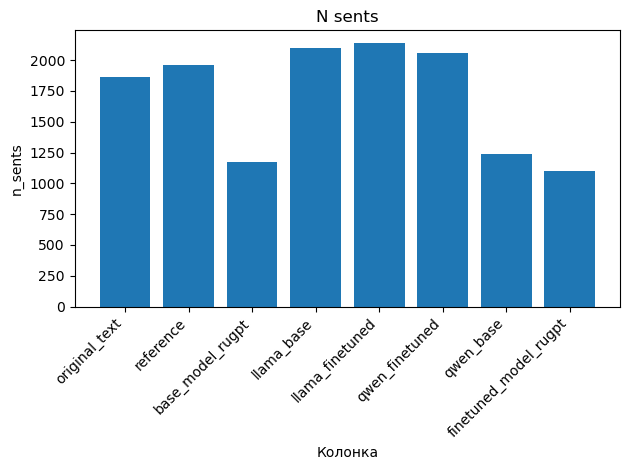

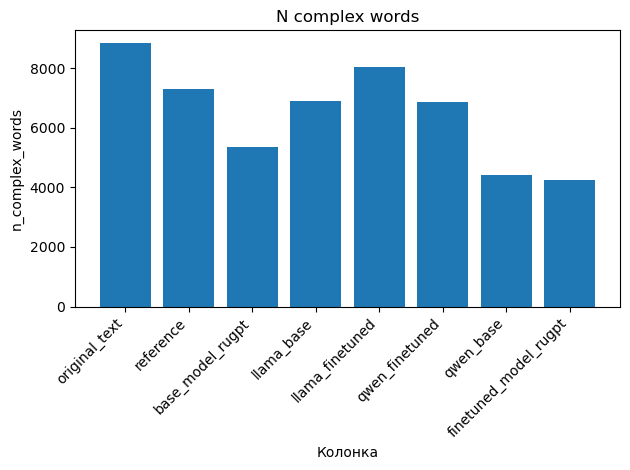

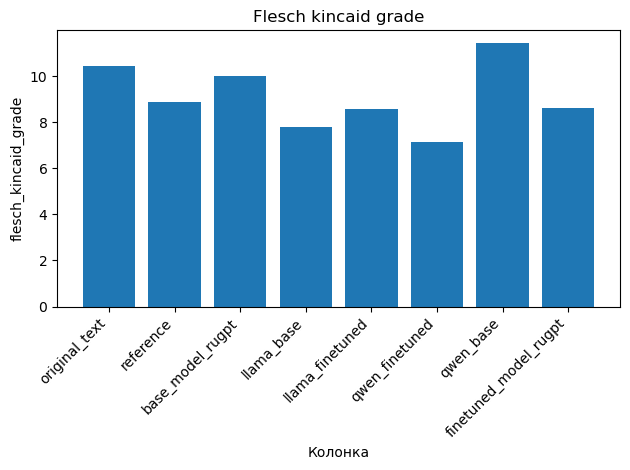

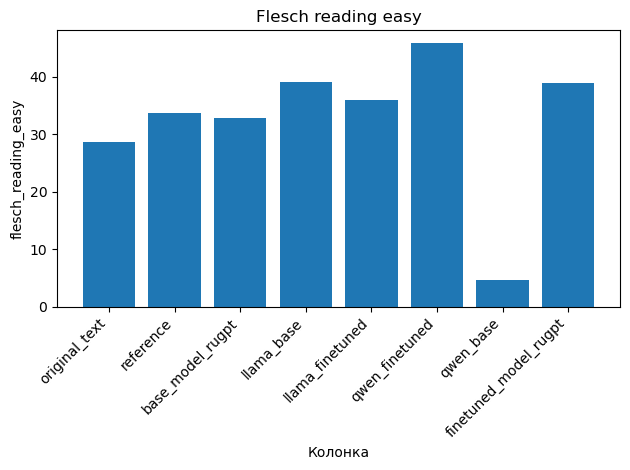

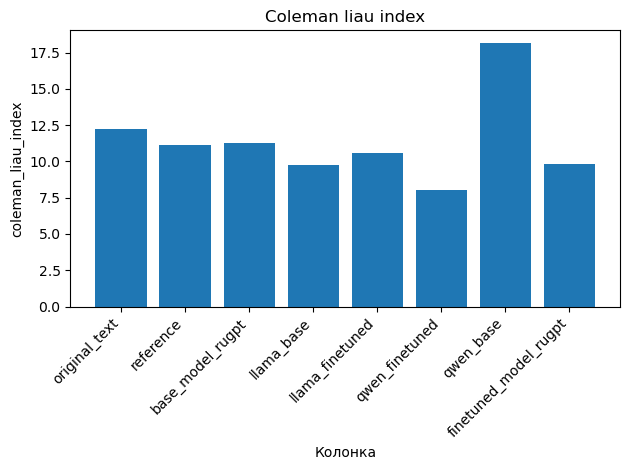

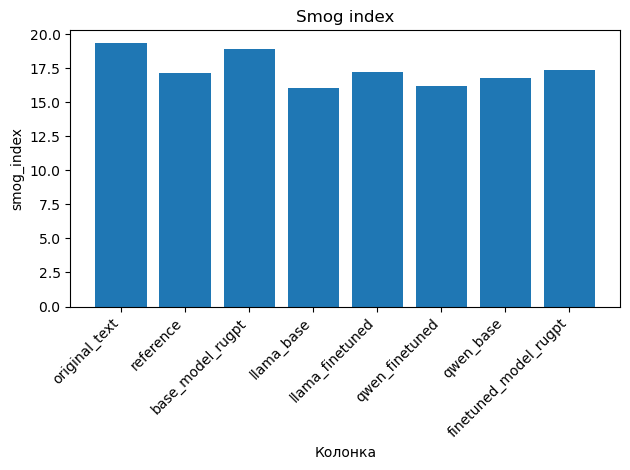

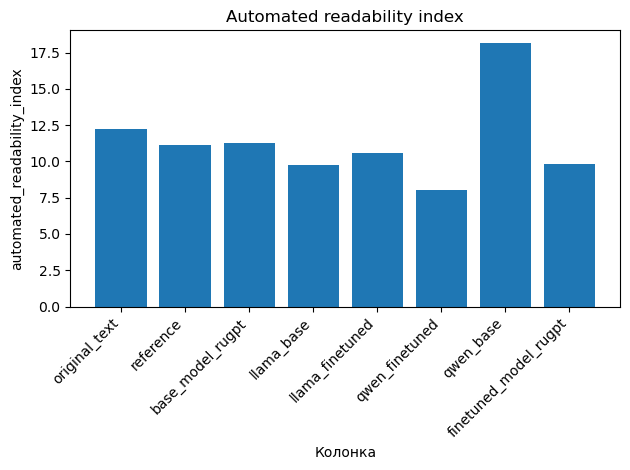

In [72]:
# 3. Сохранить в новый файл
ruts_df.to_csv('combined_ruts_all.csv', index=False)

# 4. Визуализация выбранных показателей
metrics_to_plot = [
    'n_sents', 'n_complex_words', 'flesch_kincaid_grade',
    'flesch_reading_easy', 'coleman_liau_index',
    'smog_index', 'automated_readability_index'
]

for metric in metrics_to_plot:
    plt.figure()
    plt.bar(ruts_df['column'], ruts_df[metric])
    plt.xticks(rotation=45, ha='right')
    plt.title(metric.replace('_', ' ').capitalize())
    plt.xlabel('Колонка')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()


In [74]:
ruts_df

,c_letters,c_syllables,n_sents,n_words,n_unique_words,n_long_words,n_complex_words,n_simple_words,n_monosyllable_words,n_polysyllable_words,...,hdd,simpson_index,hapax_index,flesch_kincaid_grade,flesch_reading_easy,coleman_liau_index,smog_index,automated_readability_index,lix,column
0,"{1: 3462, 2: 2236, 3: 2339, 4: 1790, 5: 2631, ...","{0: 4042, 1: 4655, 2: 6268, 3: 6247, 4: 4055, ...",1859,30044,7797,17586,8832,17170,4655,21347,...,0.946449,296.036940,1016.392349,10.425607,28.605818,12.212171,19.320757,12.212171,74.695527,original_text
1,"{1: 2791, 2: 2069, 3: 1980, 4: 1588, 5: 2421, ...","{0: 3184, 1: 4009, 2: 5827, 3: 5709, 4: 3663, ...",1959,26037,6803,15188,7308,15545,4009,18844,...,0.945686,300.488891,997.650787,8.859340,33.652678,11.094900,17.126191,11.094900,71.623338,reference
2,"{1: 2300, 2: 1610, 3: 1410, 4: 1101, 5: 1744, ...","{0: 2652, 1: 3101, 2: 4011, 3: 4065, 4: 2510, ...",1170,19170,3938,11005,5341,11177,3101,13417,...,0.932952,235.876557,866.647784,9.994627,32.764374,11.238668,18.939797,11.238668,73.792023,base_model_rugpt
3,"{1: 2714, 2: 2486, 3: 2134, 4: 1557, 5: 2403, ...","{0: 3040, 1: 4637, 2: 5677, 3: 4936, 4: 3618, ...",2101,25201,4144,13907,6911,15250,4637,17524,...,0.924089,213.737573,842.469989,7.777137,39.018363,9.727789,16.084904,9.727789,67.179082,llama_base
4,"{1: 3006, 2: 2459, 3: 2319, 4: 1676, 5: 2601, ...","{0: 4078, 1: 4218, 2: 6160, 3: 5779, 4: 3954, ...",2135,28294,6960,16233,8059,16157,4218,19998,...,0.943864,291.023824,992.434102,8.566513,35.958203,10.575825,17.227129,10.575825,70.625047,llama_finetuned
5,"{1: 2481, 2: 3628, 3: 1999, 4: 1363, 5: 2192, ...","{0: 5035, 1: 3304, 2: 5375, 3: 5236, 4: 3498, ...",2056,25815,6468,14152,6865,13915,3304,17476,...,0.906201,121.273983,1046.808105,7.138964,45.806665,8.032386,16.205398,8.032386,67.376774,qwen_finetuned
6,"{1: 1341, 2: 712, 3: 1164, 4: 675, 5: 1100, 6:...","{0: 1435, 1: 1970, 2: 2455, 3: 2549, 4: 1780, ...",1240,12834,4549,7842,4425,6974,1970,9429,...,0.947682,315.075378,1180.602584,11.417857,4.547804,18.123473,16.751472,18.123473,71.453319,qwen_base
7,"{1: 1249, 2: 1612, 3: 1434, 4: 893, 5: 1500, 6...","{0: 2865, 1: 2083, 2: 3131, 3: 3666, 4: 2114, ...",1103,15995,4606,9307,4250,8880,2083,11047,...,0.952707,348.487573,1103.965304,8.630346,38.847308,9.811932,17.404642,9.811932,72.688293,finetuned_model_rugpt


In [76]:
# Сделать имена столбцов индексом
ruts_df = ruts_df.set_index('column')
ruts_df

,c_letters,c_syllables,n_sents,n_words,n_unique_words,n_long_words,n_complex_words,n_simple_words,n_monosyllable_words,n_polysyllable_words,...,mamtld,hdd,simpson_index,hapax_index,flesch_kincaid_grade,flesch_reading_easy,coleman_liau_index,smog_index,automated_readability_index,lix
column,,,,,,,,,,,,,,,,,,,,,
original_text,"{1: 3462, 2: 2236, 3: 2339, 4: 1790, 5: 2631, ...","{0: 4042, 1: 4655, 2: 6268, 3: 6247, 4: 4055, ...",1859,30044,7797,17586,8832,17170,4655,21347,...,162.322479,0.946449,296.036940,1016.392349,10.425607,28.605818,12.212171,19.320757,12.212171,74.695527
reference,"{1: 2791, 2: 2069, 3: 1980, 4: 1588, 5: 2421, ...","{0: 3184, 1: 4009, 2: 5827, 3: 5709, 4: 3663, ...",1959,26037,6803,15188,7308,15545,4009,18844,...,160.080920,0.945686,300.488891,997.650787,8.859340,33.652678,11.094900,17.126191,11.094900,71.623338
base_model_rugpt,"{1: 2300, 2: 1610, 3: 1410, 4: 1101, 5: 1744, ...","{0: 2652, 1: 3101, 2: 4011, 3: 4065, 4: 2510, ...",1170,19170,3938,11005,5341,11177,3101,13417,...,63.534335,0.932952,235.876557,866.647784,9.994627,32.764374,11.238668,18.939797,11.238668,73.792023
llama_base,"{1: 2714, 2: 2486, 3: 2134, 4: 1557, 5: 2403, ...","{0: 3040, 1: 4637, 2: 5677, 3: 4936, 4: 3618, ...",2101,25201,4144,13907,6911,15250,4637,17524,...,65.393436,0.924089,213.737573,842.469989,7.777137,39.018363,9.727789,16.084904,9.727789,67.179082
llama_finetuned,"{1: 3006, 2: 2459, 3: 2319, 4: 1676, 5: 2601, ...","{0: 4078, 1: 4218, 2: 6160, 3: 5779, 4: 3954, ...",2135,28294,6960,16233,8059,16157,4218,19998,...,133.607189,0.943864,291.023824,992.434102,8.566513,35.958203,10.575825,17.227129,10.575825,70.625047
qwen_finetuned,"{1: 2481, 2: 3628, 3: 1999, 4: 1363, 5: 2192, ...","{0: 5035, 1: 3304, 2: 5375, 3: 5236, 4: 3498, ...",2056,25815,6468,14152,6865,13915,3304,17476,...,146.887940,0.906201,121.273983,1046.808105,7.138964,45.806665,8.032386,16.205398,8.032386,67.376774
qwen_base,"{1: 1341, 2: 712, 3: 1164, 4: 675, 5: 1100, 6:...","{0: 1435, 1: 1970, 2: 2455, 3: 2549, 4: 1780, ...",1240,12834,4549,7842,4425,6974,1970,9429,...,246.336665,0.947682,315.075378,1180.602584,11.417857,4.547804,18.123473,16.751472,18.123473,71.453319
finetuned_model_rugpt,"{1: 1249, 2: 1612, 3: 1434, 4: 893, 5: 1500, 6...","{0: 2865, 1: 2083, 2: 3131, 3: 3666, 4: 2114, ...",1103,15995,4606,9307,4250,8880,2083,11047,...,544.474225,0.952707,348.487573,1103.965304,8.630346,38.847308,9.811932,17.404642,9.811932,72.688293


In [79]:
ruts_df.to_csv('combined_ruts_all_with_names.csv', index=False)